### Grade 
6/6  - Very nice job. Your graphs look great and I love how you made a serparate block for all the user defined variables and put this at the top.

Next time I would consider weaving in your code a bit more with your narration rather than having it as a separate thing at the end. One of the benefits of a notebook is you can have your discussion woven together with your results as they are generated. It would be better in this case to have your code blocks spearted out so that there can be markdown sections in between which discuss each plot as it is generated. Also in the future you can try defining functions in a separte file and sourcing them. 



# Week 13 (1/23/2020). Lourdes Fierro
## Forecast analysis

### 1. Purpose of the notebook.
This notebook is created to show one simple approach for streamflow prediction at Verde River Near Camp Verde Station. The data used in this work is streamflow at the same station 09506000 Verde River Near Camp Verde obtained from the 
[USGS](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=09506000) website. Code is included at the end of the notebook
### 2. How is the forecaste generated? Why?
The forecast is estimated using an Autoregressive Model (AR). The model is trained with streamflow data from '2016-01-01'(start date) to '2019-12-31'(end data) that is laged one week. In order to compute the AR model, the data used is converted into logaritmic data in order to decrease huge influence from high/low values (extremes). After the AR model is trained and tested, the slope, intercept, coefficient of determination are estmaestimated (sklearn library). The model incorporates only streamflow data because this work intentes to keep a simple approach. The solpe and intercept from this model are used to estimate the streamflow with the linear regression equation, however some adjustments are included (standard deviation of some data is included). It is importan to metion that the data is lagged 1 week, therfore the outputs are delayed by one week too. More details can be consulted in the code. 
### 3. Forecasting evolution over time
During the first two/three weeks of the semester, the forecastion was done making guesses from looking at the data from specific years. For weeks three to 5 the forecast kept the guess approach, however a timeseries plot was elaborated, so the guesses were less random and with more context. For the next weeks, the AR model was implemented and its prediction were used as basis to make forecast, however, becuase the training data was raw with no processing/transformation, the model outputs seemed off and they were not exaclyt used. For the previous three weeks, the logaritmic tranformation of the data has been included and the model outputs havee improved, so know its direct outputs are submitted to the week and seasonal forecast competition.  

### 4. Predictions:
- Week 1 & Week 2 Forecast:
176.65 & 192.67

- Seasonal Forecast:
Week 1 forecast using model is: 43.28
Week 2 forecast using model is: 45.31
Week 3 forecast using model is: 48.26
Week 4 forecast using model is: 51.30
Week 5 forecast using model is: 54.08
Week 6 forecast using model is: 56.52
Week 7 forecast using model is: 63.00
Week 8 forecast using model is: 73.51
Week 9 forecast using model is: 89.18
Week 10 forecast using model is: 112.48
Week 11 forecast using model is: 125.31
Week 12 forecast using model is: 145.84
Week 13 forecast using model is: 160.98
Week 14 forecast using model is: 176.65
Week 15 forecast using model is: 192.67
Week 16 forecast using model is: 216.09

### 5. Map

![](map.png)


### 6. Plots
![](Flow.png)

![](Scatter.png)

### 7. Code
#### a) Libraries that need to in the conda enviroment (hastools).
Libraries that are not available in the enviroment need to be installed. It is recommended to do it using ``` conda install -c conda-forge package_name``` 


In [130]:
import os
import math
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import json 
import urllib.request as req
import urllib
from eval_functions import getstrm_wbs
from eval_functions import add_yymmdd
from eval_functions import mono_reg_mod
from eval_functions import flow_predic_mono
from eval_functions import week_prediction_all
from eval_functions import down_map_var
import contextily as ctx
from shapely.geometry import Point
import geopandas as gpd
import fiona
import matplotlib as mpl
from netCDF4 import Dataset
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import fiona
import shapely


#### b) Establish dates and variables that won't change
- Station id (streamflow)
- Start/End dates AR training data
- No. of lag (training data)
- Forecast weeks (1 &  2)
- End date of streamfow data that is going to be downloaded.

In [131]:
# %% Define trainning period
station_id = '09506000'  # Streamflow station
trainstart = '2016-01-01'  # Start date to train AR model
trainend = '2019-12-31'  # end date to train AR model
lag = 2  # No. of weeks to consider for lag 
end_date = '2020-11-21'  # yyyy-mm-dd (changes each week)
forecast_week_1_2 = ['2020-11-22','2020-11-29']
week_no_fore = 13 # This week forecast no.

#### c) Streamflow section
getstrm_wbs function is used to download data from the [USGS](hhttps://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=09506000) website. Data range: 1989-01-01 to 'end_date'. Frequency: 24 hrs (daily)
Weely flow is computed and added. Data is transformed into natural log to fit the model better

In [132]:
# Get streamflow from website using getstrm_wbs function
flow_data = getstrm_wbs(station_id,end_date)  # download strmflow from website
# Data formatting
flow_data_pd = add_yymmdd(flow_data)  # add year,month,day (easier to wrok with)
flow_weekly = flow_data_pd.resample("W", on='datetime').mean()  # Add flow values to weekly
flow_weekly.insert(2, 'log_flow', np.log(flow_weekly['flow']), True)  # Natural log (fits the model better)

#### d) Autoregressive model
- Step 1: Setup  arrays to build the model, based on lagged timeseries
- step 2: Pick time series portion to train model
- Step 3: Fit AR model (linear regression model using sklearn, 1 var)

In [133]:
# %% Step 1: Fit AR model (linear regression model using sklearn, 1 var)
shifts = list(range(1, lag+1))
flow_weekly['log_flow_tm1'] = flow_weekly['log_flow'].shift(shifts[0])  # Lag 1week
flow_weekly['log_flow_tm2'] = flow_weekly['log_flow'].shift(shifts[1])  # Lag 2weeks

# %% Step 2: Pick time series portion to train model
print('Start training week: ', trainstart)
print('End training week: ', trainend)

# Dropping first two weeks (won't have lagged data) to go with them
train = flow_weekly[trainstart:trainend][['log_flow',
                                          'log_flow_tm1', 'log_flow_tm2']]
test = flow_weekly[trainend:][['log_flow',
                               'log_flow_tm1', 'log_flow_tm2']]
# %% Step 3
b, m, reg_model1, coeff_det1 = mono_reg_mod(train)

# Step 4 verify
predi_train = reg_model1.predict(train['log_flow_tm1'].values.reshape(-1, 1))
predi_test = reg_model1.predict(test['log_flow_tm1'].values.reshape(-1, 1))

Start training week:  2016-01-01
End training week:  2019-12-31
coefficient of determination: 0.776843
Final equation is y1 = : [0.8851347] x +  0.5907568


#### e) Week 1 & Week 2 forecast
1. Last week flow is estimated from the data to know current streamflow conditions.
2. Weeks to be predicted are defined, and the varaibles from the previos AR model are used to estimate two weeks forecast.

In [134]:
# %% Getting our two week predictions!
# Geting last weeks flow
week_before_flow = flow_weekly['log_flow'].tail(1)
print("Last weeks's flow was", math.exp(week_before_flow),'cfs!', '\n')

# Defining prediction weeks for our 2 week predic.
# These are the weeks we will be predicting for our 2 week predictions.
print(flow_predic_mono(b, m, 2, week_before_flow, forecast_week_1_2), '\n')


Last weeks's flow was 155.83333333333331 cfs! 

            Predicted_Flows_Lin:
2020-11-22            157.529607
2020-11-29            159.046435 



#### d) Seasonal forecast (16 weeks)
1. Number of weeks to be considered to estimate weekly seasonal forecast (begining_week_ly and ending_week_ly)
2. Weekly prediction is done using week_prediction_all function which uses AR parameters (previously estimated) and the mean flow from previos step. 


In [135]:
# %% 16 week forecast taking previous 15 weeks mean before week to forecast
no_weeks = flow_weekly['log_flow'].size  # Number of weeks up to date

begining_week_ly = week_no_fore + 15  # start week year 2020
ending_week_ly = week_no_fore  # end week year 2020
dates_weeks_range = flow_weekly['log_flow'][no_weeks-begining_week_ly:
                                           no_weeks-ending_week_ly] 
# print('Weeks date to be considered in the forecast estimation',dates_weeks_range[0])

wk_prd = np.zeros(16)
for i in range(1,17):
       wk_prd = week_prediction_all(flow=flow_weekly, m=m, b=b,
                                    prev_wks=begining_week_ly, end=ending_week_ly, week_pred=i)
       begining_week_ly = begining_week_ly+1
       ending_week_ly = ending_week_ly +1

Week 1 forecast using model is: 43.2867729870689 Correction factor: 0.2
Week 2 forecast using model is: 45.31624808250473 Correction factor: 0.2
Week 3 forecast using model is: 48.267285232107014 Correction factor: 0.2
Week 4 forecast using model is: 51.3013690567997 Correction factor: 0.2
Week 5 forecast using model is: 54.08575181023021 Correction factor: 0.2
Week 6 forecast using model is: 56.523858855612495 Correction factor: 0.2
Week 7 forecast using model is: 63.00298998924322 Correction factor: 0.2
Week 8 forecast using model is: 73.51826132230393 Correction factor: 0.2
Week 9 forecast using model is: 89.18724366987658 Correction factor: 0.2
Week 10 forecast using model is: 112.48975081220152 Correction factor: 0.2
Week 11 forecast using model is: 125.3178545321986 Correction factor: 0.2
Week 12 forecast using model is: 145.84825520640948 Correction factor: 0.2
Week 13 forecast using model is: 160.98181510805125 Correction factor: 0.2
Week 14 forecast using model is: 176.6524646

#### 4. Plots
1. Streamflow timeseries plot (July to December since 1989 until 2020)
2. Scatter plot test weeks vs AR model

Method of flow quantiles for month                              flow code   site_no                  datetime  \
datetime                                                                    
1989-08-01 00:00:00+00:00  146.0    A  09506000 1989-08-01 00:00:00+00:00   
1989-08-02 00:00:00+00:00  137.0    A  09506000 1989-08-02 00:00:00+00:00   
1989-08-03 00:00:00+00:00  130.0    A  09506000 1989-08-03 00:00:00+00:00   
1989-08-04 00:00:00+00:00  178.0    A  09506000 1989-08-04 00:00:00+00:00   
1989-08-05 00:00:00+00:00  196.0    A  09506000 1989-08-05 00:00:00+00:00   
...                          ...  ...       ...                       ...   
2020-11-17 00:00:00+00:00  161.0    P  09506000 2020-11-17 00:00:00+00:00   
2020-11-18 00:00:00+00:00  154.0    P  09506000 2020-11-18 00:00:00+00:00   
2020-11-19 00:00:00+00:00  153.0    P  09506000 2020-11-19 00:00:00+00:00   
2020-11-20 00:00:00+00:00  153.0    P  09506000 2020-11-20 00:00:00+00:00   
2020-11-21 00:00:00+00:00  152.0    P  0

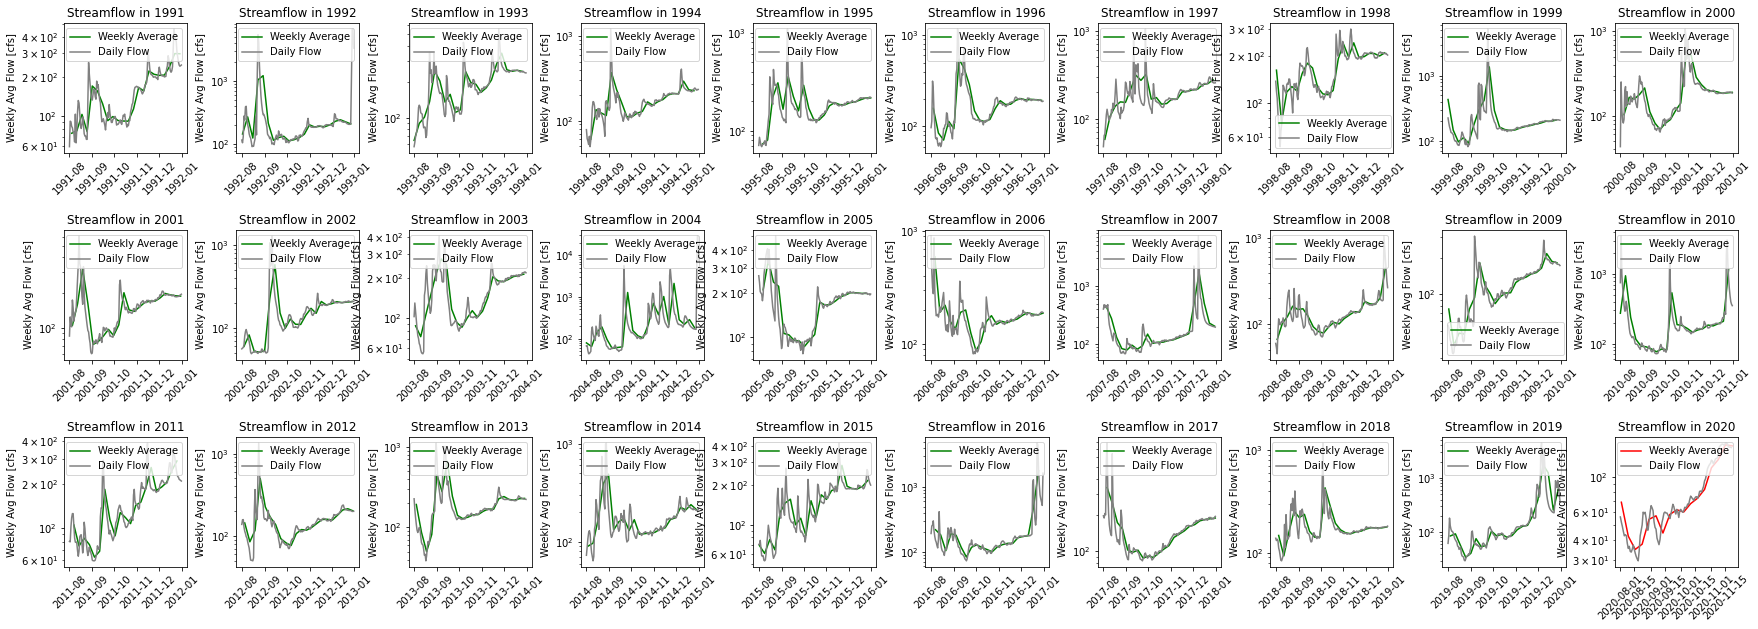

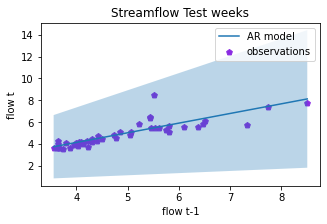

In [136]:
# %% Graph function, to adjust for naming differences
# flow_weekly_mnth_i in the for loop
data_mnth = flow_data_pd[flow_data_pd['month'] > 7]  # Months to consider in the plot
flow_weekly_mnth = flow_weekly[flow_weekly['month'] > 7] 
flow_quants_mnth = np.quantile(flow_weekly_mnth['flow'], q=[0, 0.5, 0.75, 0.9])  # Quantile format
print('Method of flow quantiles for month ', data_mnth, ':', flow_quants_mnth)
print('For plots, Green is flow max above 75%, and Red is below 50%')
fig = plt.figure(figsize=(30, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(1, 31):
    curr_yr = (i + 1990)
    flow_weekly_mnth_i = flow_weekly_mnth[flow_weekly_mnth['year'] ==
                                          curr_yr]
    data_mnth_i = data_mnth[data_mnth['year'] == curr_yr]
    ax = fig.add_subplot(3, 10, i)
    ax.set(title=("Streamflow in " + str(curr_yr)),
           ylabel="Weekly Avg Flow [cfs]", yscale='log')
    plt.xticks(rotation=45)
    if (np.max(flow_weekly_mnth_i['flow']) > flow_quants_mnth[2]):
        ax.plot(flow_weekly_mnth_i['flow'],
                '-g', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey',
                label='Daily Flow')
        ax.legend()
    elif (np.max(flow_weekly_mnth_i['flow']) < flow_quants_mnth[1]):
        ax.plot(flow_weekly_mnth_i['flow'],
                '-r', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey',
                label='Daily Flow')
        ax.legend()
    else:
        ax.plot(flow_weekly_mnth_i['flow'],
                '-b', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey', 
                label='Daily Flow')
        ax.legend()
fig.savefig("Flow.png")
        
# Scatter plot test weeks vs AR model
# Test streamflow values
fig, ax = plt.subplots()
ax.scatter(test['log_flow_tm1'], test['log_flow'], marker='p',
           color='blueviolet', label='observations')
ax.set(title="Streamflow Test weeks", xlabel='flow t-1', ylabel='flow t')
ax.plot(np.sort(test['log_flow_tm1']), np.sort(predi_test), label='AR model')
ax.fill_between(np.sort(test['log_flow_tm1']), np.sort(predi_test) -
                coeff_det1*np.sort(predi_test), np.sort(predi_test) +
                coeff_det1*np.sort(predi_test), alpha=0.3)
ax.legend()
fig.set_size_inches(5, 3)
fig.savefig("Scatter.png")

#### 5. Map
Data included:
- Gauges II [USGS](https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder) stream gauge dataset
- Watershed boundaries for the lower colorado [USGS](https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View)
- Forest
- Rivers and streamflow

Images are included below:

/Users/lourdesfierro/miniconda3/envs/hastools/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
<ipython-input-137-f4fc750fe6c9>:55: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax=ax, url=ctx.providers.OpenTopoMap,)


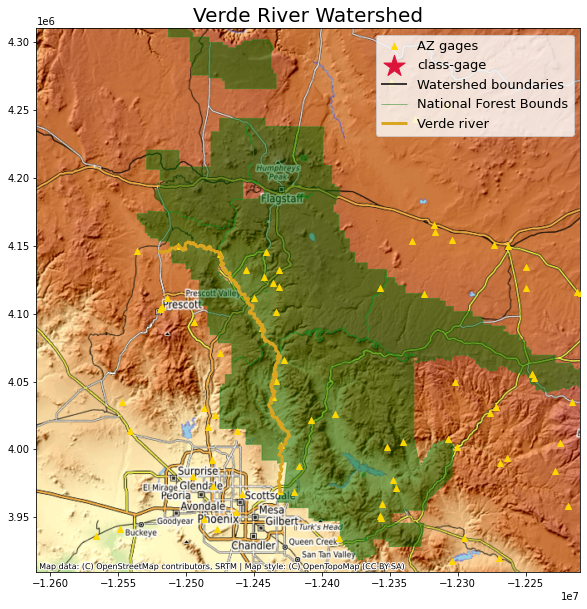

In [137]:
# %% Get variables to map
# Map Gauges II USGS stream gauge dataset:

filepath = os.path.join('../data')  # Path where data is storage
state= 'AZ' #  state
gages_AZ = down_map_var(filepath,0,state)

# Watershed boundaries for the lower colorado
filepath_bd = '../data/map/Shape'
HUC6 = down_map_var(filepath_bd,1,state)

# Forest
filepath_fr = '../data/map'
forest = down_map_var(filepath_fr,2,state)
forests_az = ['Kaibab National Forest', 'Prescott National Forest',
              'Coconino National Forest', 'Tonto National Forest',
              'Apache-Sitgreaves National Forests', 'Coronado National Forest']
forest_az=forest[forest['FORESTNAME'].isin(forests_az)]

# Rivers and stream
filepath_rv = '../data/map/USA_Rivers_and_Streams-shp'
rivers_AZ = down_map_var(filepath_rv,3,state)
rivers_AZ.columns
rivers_AZ.Name.unique()
river_verde = rivers_AZ[rivers_AZ['Name'] == 'Verde River']

# Stream gauge location
point_list = np.array([[-111.7891667, 34.44833333]])
point_geom = [Point(xy) for xy in point_list]  # Make it spatial
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC6.crs)  #mape a dataframe of these points
# %%
# Adding a basemap, correcting crs to align on basemap
# This aligns the basemap with the other layers
points_project = point_df.to_crs(epsg=3857)
gages_AZ = gages_AZ.to_crs(epsg=3857)
HUC6_project = HUC6.to_crs(epsg=3857)
forest_az = forest_az.to_crs(epsg=3857)
river_verde = river_verde.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
xlim = ([-1.261e7, -1.221e7])
ylim = ([3.91e6, 4.31e6])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
gages_AZ.plot(column='DRAIN_SQKM', categorical=False,
              legend=True, markersize=35, label='AZ gages', marker='^', color='gold',
              ax=ax, zorder=3)
points_project.plot(ax=ax, color='crimson',markersize=500, marker='*', label='class-gage', zorder=5 )
HUC6_project.boundary.plot(ax=ax, color=None, label='Watershed boundaries',
                           edgecolor='black', linewidth=1.5, zorder=1)
forest_az.boundary.plot(ax=ax, label='National Forest Bounds', alpha= 0.5,
                             facecolor='darkgreen', edgecolor='forestgreen',
                             linewidth=1, zorder=2)
river_verde.plot(ax=ax, linewidth=3, color='goldenrod', zorder=4, label='Verde river')
ctx.add_basemap(ax=ax, url=ctx.providers.OpenTopoMap,)
ax.set_title('Verde River Watershed', fontsize=20)
ax.legend(loc='upper right', fontsize=13)
plt.show()
fig.savefig("Map.png")